<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro</a></span></li><li><span><a href="#Librairies-and-modules-importation" data-toc-modified-id="Librairies-and-modules-importation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Librairies and modules importation</a></span></li><li><span><a href="#Targets-Loading" data-toc-modified-id="Targets-Loading-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Targets Loading</a></span></li><li><span><a href="#Custom-modules" data-toc-modified-id="Custom-modules-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Custom modules</a></span><ul class="toc-item"><li><span><a href="#Custom-metric-callback" data-toc-modified-id="Custom-metric-callback-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Custom metric callback</a></span></li><li><span><a href="#Custom-data-loader" data-toc-modified-id="Custom-data-loader-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Custom data loader</a></span></li><li><span><a href="#Resizing-function" data-toc-modified-id="Resizing-function-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Resizing function</a></span></li></ul></li><li><span><a href="#Model-definition" data-toc-modified-id="Model-definition-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model definition</a></span></li><li><span><a href="#Training-function-:" data-toc-modified-id="Training-function-:-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training function :</a></span></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Model training</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Recall-scores-on-validation-set" data-toc-modified-id="Recall-scores-on-validation-set-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Recall scores on validation set</a></span></li><li><span><a href="#Losses-on-validation-set" data-toc-modified-id="Losses-on-validation-set-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Losses on validation set</a></span></li><li><span><a href="#Losses-on-training-set" data-toc-modified-id="Losses-on-training-set-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Losses on training set</a></span></li></ul></li><li><span><a href="#Inference" data-toc-modified-id="Inference-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Inference</a></span></li></ul></div>

# Intro

This notebook show how to use Keras to build and train a simple CNN with Keras to detect the components of Bengali graphemes. 
It relies heavily on [this very interesting notebook from Kaushal Shah](https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn#Basic-Model) that lays the basics to get started and helped me a lot.  
Main modifications are :
- Added Keras callback to be able to track the competition metrics (weighted average of recall)
- Modified training loop to train over all data before starting a new epoch (data format need to be changed to feather and saved as dataset before starting in order to not increase training time too much, see [this very handy notebook by Maxime Lenormand](https://www.kaggle.com/maxlenormand/cropping-to-character-resizing-images)). This remove loss spike when switching train dataset while training.
- Giving a bit more structure / modularity by introducing functions for model creation and training
- Higher image resolution used (80x80), once again see Maxime Lenormand notebook to see preprocessing

# Librairies and modules importation

In [1]:
import gc
from tqdm import tqdm

# OpenCV for image manipulation
import cv2

# Librairies for data manipulation and linear algebra
import numpy as np 
import pandas as pd

# Scikit learn modules for data preprocessing and metrics calculation
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

# Keras modules for CNN construction and training
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input, AveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import Callback

# Visualization tools
from keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_0.feather
/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_1.feather
/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_2.feather
/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_3.feather
/kaggle/input/bengaliai-cv19/test_image_data_0.parquet
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/train.csv


# Targets Loading

In [2]:
train_target = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv', index_col='image_id')

In [3]:
rootLB = LabelBinarizer()
vowelLB = LabelBinarizer()
consonantLB = LabelBinarizer()
rootLB.fit(train_target['grapheme_root'])
vowelLB.fit(train_target['vowel_diacritic'])
consonantLB.fit(train_target['consonant_diacritic'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

# Custom modules

## Custom metric callback

Creation of a callback that will be called at the end of each epoch to compute the recall for the 3 targets and the final score (weighted average of recall scores).

In [4]:
class validation_recall(keras.callbacks.Callback):
    
    def __init__(self, validation_data=()):
        super(keras.callbacks.Callback, self).__init__()
        self.X_val, self.y_val = validation_data
    
    def on_epoch_end(self, epoch, logs={}):

        root_val = self.y_val[0]
        vowel_val = self.y_val[1]
        consonant_val = self.y_val[2]
        
        # Predictions on validation set for the 3 targets 
        #(+ one hot encoding)
        preds = self.model.predict(self.X_val)
        
        root_preds = np.zeros_like(preds[0])
        root_preds[np.arange(len(preds[0])), 
                   preds[0].argmax(axis=1)] = 1
        
        vowel_preds = np.zeros_like(preds[1])
        vowel_preds[np.arange(len(preds[1])), 
                    preds[1].argmax(axis=1)] = 1
        
        consonant_preds = np.zeros_like(preds[2])
        consonant_preds[np.arange(len(preds[2])), 
                        preds[2].argmax(axis=1)] = 1
        
        # Recall calculation for the 3 targets
        root_recall = recall_score(root_val, root_preds, 
                                   average='macro')
        vowel_recall = recall_score(vowel_val, vowel_preds, 
                                    average='macro')
        consonant_recall = recall_score(consonant_val, consonant_preds, 
                                        average='macro')
        final_score = np.average([root_recall, vowel_recall, 
                                  consonant_recall], weights=[2,1,1])
        
        # Displaying scores at the end of each epoch
        print(' - root_recall: {0:.4f}'.format(root_recall)+\
              ' - vowel_recall: {0:.4f}'.format(vowel_recall)+\
              ' - consonant_recall: {0:.4f}'.format(consonant_recall)+\
              ' - final_score: {0:.4f}'.format(final_score))

        # Saving scores in logs history
        logs['root_recall'] = root_recall
        logs['vowel_recall'] = vowel_recall
        logs['consonant_recall'] = consonant_recall
        logs['final_score'] = final_score

## Custom data loader

Keras DataGenerator modified for multi-outputs model taken from [this very interesting notebook](https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn#Basic-Model) from Kaushal Shah. It will allow to generate a batch of data to feed the model while training to avoid memory shortage.

In [5]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, 
                                         batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

## Resizing function

Resizing function taken from [this very handy notebook by Maxime Lenormand](https://www.kaggle.com/maxlenormand/cropping-to-character-resizing-images). Train data have been preprocessed before and loaded as a dataset, the function will only be used on test set for preprocessing before inference.

In [6]:
HEIGHT = 137
WIDTH = 236
CROP_SIZE = 80

In [7]:
def crop_and_resize_images(df, resized_df, resize_size = CROP_SIZE):
    cropped_imgs = {}
    for img_id in tqdm(range(df.shape[0])):
        img = resized_df[img_id]
        _, thresh = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
        
        idx = 0 
        ls_xmin = []
        ls_ymin = []
        ls_xmax = []
        ls_ymax = []
        for cnt in contours:
            idx += 1
            x,y,w,h = cv2.boundingRect(cnt)
            ls_xmin.append(x)
            ls_ymin.append(y)
            ls_xmax.append(x + w)
            ls_ymax.append(y + h)
        xmin = min(ls_xmin)
        ymin = min(ls_ymin)
        xmax = max(ls_xmax)
        ymax = max(ls_ymax)

        roi = img[ymin:ymax,xmin:xmax]
        resized_roi = cv2.resize(roi, (resize_size, resize_size))
        cropped_imgs[df.image_id[img_id]] = resized_roi.reshape(-1)
        
    resized = pd.DataFrame(cropped_imgs).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized #out_df

# Model definition

In [8]:
def create_multi_outputs_model():
    
    # Input layer (change shape according to your image size)
    inputs = Input(shape=(80,80,1))
    
    # First convolution block
    x = Conv2D(32, (3, 3), padding="same", activation='relu')(inputs)
    x = Conv2D(32, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(32, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(32, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    
    # Second convolution block
    x = Conv2D(64, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(64, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(64, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(64, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    
    # Third convolution block
    x = Conv2D(128, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(128, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(128, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(128, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    
    # Fourth convolution block
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = AveragePooling2D(pool_size=(3, 3), padding='valid')(x)
    
    # Classification layers
    x = Flatten()(x)
    x = Dense(512, activation = "relu")(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(256, activation = "relu")(x)
    x = Dropout(rate=0.3)(x)
    
    # Output layers
    root_out = Dense(168, activation='softmax', name='root_output')(x)
    vowel_out = Dense(11, activation='softmax', name='vowel_output')(x)
    consonant_out = Dense(7, activation='softmax', name='consonant_output')(x)
    
    # model assembly
    model = Model(inputs=inputs, outputs=[root_out, vowel_out, consonant_out])
    
    return model

# Training function :

This training function is using the following process :
* Loading a set of images and targets data (from one of the four images files)
* Reshape images data to numpy array with correct dimensions (80 x 80)
* One hot encoding of the 3 targets
* Separate all sets in two : training set and validation set
* Creating Keras data generators to load data batch by batch in the model
* Train the model

The inner loop train the model for 1 epoch on the four train sets one after the other and the outer loop allow to repeat this operation X times, thus controlling the number of epochs over all data.

In [9]:
def train_model(model, epochs, batch_size):
    complete_history = []
    for j in range(epochs):
        print('current epoch : ' + str(j+1) + ' / ' + str(epochs))
        for i in range(4):

            # Images + targets loading and merging
            train_data = pd.read_feather('/kaggle/input/bengali-graphemes-'
                                         'croppedresized-100x100-train/'
                                         f'train_data_{i}.feather')
            train_data.set_index(keys=['image_id'], drop=True, inplace=True)
            train_df = pd.merge(train_data, train_target, 
                                on='image_id').drop(['grapheme'], axis=1)

            # Deleting previous variables to free up memory
            del train_data
            gc.collect()

            # One hot encoding the 3 targets with sklearn LabelBinarizer
            #rootLB = LabelBinarizer()
            #vowelLB = LabelBinarizer()
            #consonantLB = LabelBinarizer()
            rootLabels = rootLB.transform(train_df['grapheme_root'])
            vowelLabels = vowelLB.transform(train_df['vowel_diacritic'])
            consonantLabels = consonantLB.transform(
                              train_df['consonant_diacritic'])

            # Reshape images data to numpy array with same dimensions 
            # as images (80 x 80)
            train_df.drop(['grapheme_root', 'vowel_diacritic', 
                           'consonant_diacritic'], axis=1, inplace=True)
            train_df = train_df / 255
            train_images = train_df.values.reshape(-1, 80, 80, 1)

            # Deleting previous variables to free up memory
            del train_df
            gc.collect()

            # Creating Train / validation set for images and 3 targets
            X_train, X_val, y_train_root, y_val_root, y_train_vowel, \
            y_val_vowel, y_train_consonant, y_val_consonant \
            = train_test_split(train_images, rootLabels, vowelLabels, 
                               consonantLabels, test_size=0.2, 
                               random_state=42)

            # Deleting previous variables to free up memory
            del train_images
            del rootLabels, vowelLabels, consonantLabels
            gc.collect()

            # Creation of Keras Datagenerator configuration 
            # without data augmentation
            datagen = MultiOutputDataGenerator(
            featurewise_center=False,  
            samplewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            zca_whitening=False,
            rotation_range=0,
            zoom_range=0,
            width_shift_range=0,
            height_shift_range=0,
            horizontal_flip=False,
            vertical_flip=False)

            ''' You can use this piece of code (and removing everything below it) to  
                have insight of how the datagen works and how batch are structured

            i = 0
            for batch in datagen.flow(X_train, 
                                     {'root': y_train_root, 
                                     'vowel': y_train_vowel, 
                                     'consonant': y_train_consonant},
                                      batch_size=1, save_to_dir=None):
                print(i)
                print('batch infos :')
                print(f'type : {type(batch)}')
                print(f'length type : {len(batch)}')
                print('features infos :')
                print(f'type : {type(batch[0])}')
                print(f'shape : {batch[0].shape}')
                print('Target infos :')
                print(f' global type : {type(batch[1])}')
                print(f'global shape : {len(batch[1])}')
                print(f'first target shape : {batch[1]["root"].shape}')
                print(f'second target shape : {batch[1]["vowel"].shape}')
                print(f'third target shape : {batch[1]["consonant"].shape}')

                i += 1
                if i > 5:
                    break  # otherwise the generator would loop indefinitely

            '''
            # creation of data generator for training set
            train_generator = datagen.flow(X_train,
                                           {'root_output': y_train_root, 
                                            'vowel_output': y_train_vowel, 
                                            'consonant_output': y_train_consonant},
                                           batch_size=batch_size)

            # creation of data generator for validation set
            val_generator = datagen.flow(X_val,
                                         {'root_output': y_val_root, 
                                          'vowel_output': y_val_vowel, 
                                          'consonant_output': y_val_consonant},
                                         batch_size=batch_size)

            # Creation of callback for metric calculation
            # after each epoch
            my_call = validation_recall(validation_data=(X_val,
                                                         [y_val_root,
                                                          y_val_vowel, 
                                                          y_val_consonant]))

            # Model training
            history = model.fit_generator(
                    train_generator,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=1,
                    validation_data=val_generator,
                    validation_steps=X_val.shape[0] // batch_size,
                    callbacks=[my_call])

            # Appending training history to the one of previous step
            complete_history.append(history.history)

            del train_generator
            del val_generator
            del my_call
            del X_train
            del X_val
            del y_train_root
            del y_val_root
            del y_train_vowel
            del y_val_vowel
            del y_train_consonant
            del y_val_consonant
            gc.collect()

    return model, complete_history

# Model training

In [10]:
# Model creation
model = create_multi_outputs_model()

In [11]:
# Model structure
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 80, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 80, 80, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 80, 80, 32)   9248        conv2d_2[0][0]                   
____________________________________________________________________________________________

In [12]:
# Model compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=None)

In [13]:
# Model training
trained_model, history = train_model(model=model, epochs=40, 
                                     batch_size=256)

current epoch : 1 / 40
Epoch 1/1
156/156 [==============================] - 46s 292ms/step - loss: 6.5535 - root_output_loss: 4.5750 - vowel_output_loss: 1.0692 - consonant_output_loss: 0.9092 - val_loss: 5.3230 - val_root_output_loss: 4.1394 - val_vowel_output_loss: 0.7550 - val_consonant_output_loss: 0.6912
 - root_recall: 0.0248 - vowel_recall: 0.6447 - consonant_recall: 0.5332 - final_score: 0.3068
Epoch 1/1
156/156 [==============================] - 39s 252ms/step - loss: 4.5658 - root_output_loss: 3.5072 - vowel_output_loss: 0.5504 - consonant_output_loss: 0.5082 - val_loss: 3.6461 - val_root_output_loss: 2.7188 - val_vowel_output_loss: 0.4629 - val_consonant_output_loss: 0.3962
 - root_recall: 0.2181 - vowel_recall: 0.7409 - consonant_recall: 0.6428 - final_score: 0.4550
Epoch 1/1
156/156 [==============================] - 39s 252ms/step - loss: 2.9803 - root_output_loss: 2.2378 - vowel_output_loss: 0.4113 - consonant_output_loss: 0.3313 - val_loss: 2.3584 - val_root_output_loss

In [14]:
# Model saving
trained_model.save('multi_outputs_model_V2.h5')

# Results

In [15]:
# Creation of dataframe containing results
results_df = pd.DataFrame(columns=['val_loss', 'val_root_output_loss', 
                                   'val_vowel_output_loss','val_consonant_output_loss',
                                   'loss', 'root_output_loss','vowel_output_loss',
                                   'consonant_output_loss', 'root_recall',
                                   'vowel_recall', 'consonant_recall', 'final_score'])
for hist in history:
    results_df = results_df.append(pd.DataFrame(hist), ignore_index=True)

In [16]:
display(results_df)

,val_loss,val_root_output_loss,val_vowel_output_loss,val_consonant_output_loss,loss,root_output_loss,vowel_output_loss,consonant_output_loss,root_recall,vowel_recall,consonant_recall,final_score
0,5.322989,4.139367,0.755043,0.691150,6.553450,4.575033,1.069245,0.909174,0.024757,0.644683,0.533201,0.306849
1,3.646111,2.718836,0.462910,0.396200,4.565792,3.507211,0.550379,0.508203,0.218134,0.740859,0.642844,0.454993
2,2.358420,1.575242,0.401552,0.323456,2.980324,2.237770,0.411290,0.331264,0.508150,0.841203,0.701533,0.639759
3,1.265876,0.907836,0.189432,0.177273,1.999348,1.423354,0.319018,0.256977,0.693888,0.906038,0.913075,0.801722
4,1.049138,0.696662,0.156931,0.144668,1.495105,1.021976,0.261809,0.211320,0.753350,0.928981,0.905688,0.835342
...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.899996,0.402014,0.104297,0.099449,0.070301,0.041967,0.015405,0.012928,0.931042,0.979036,0.971608,0.953182
156,0.284982,0.378748,0.123638,0.120615,0.064852,0.038701,0.015506,0.010645,0.918023,0.975260,0.970039,0.945336
157,0.461494,0.391478,0.110536,0.113875,0.071777,0.044418,0.015560,0.011799,0.928729,0.977044,0.967612,0.950529
158,0.484398,0.374548,0.104981,0.112200,0.073377,0.047639,0.015342,0.010397,0.929402,0.972754,0.959653,0.947803


## Recall scores on validation set

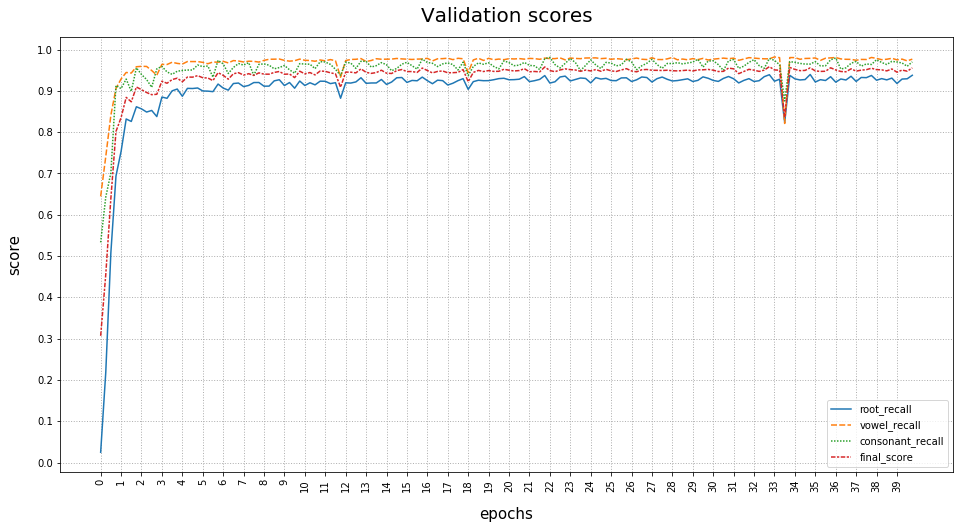

In [17]:
# displaying recall score on validation set

fig, ax = plt.subplots(figsize=(16,8))
ax = sns.lineplot(data=results_df.loc[:,['root_recall', 'vowel_recall', 
                                         'consonant_recall', 'final_score']],
                                         linestyle=None)

ax.set_xlabel('epochs', labelpad=15, fontsize=15)
ax.set_ylabel('score', labelpad=15, fontsize=15)
ax.set_title('Validation scores', pad=15, fontsize=20)
plt.xticks(ticks=np.arange(0,results_df.shape[0],4), 
           labels=np.arange(0,int(results_df.shape[0]/4),1).tolist(), rotation=90)
plt.yticks(np.arange(0,1.1,0.1))
ax.grid(axis='both', linestyle=':', linewidth=1)

## Losses on validation set

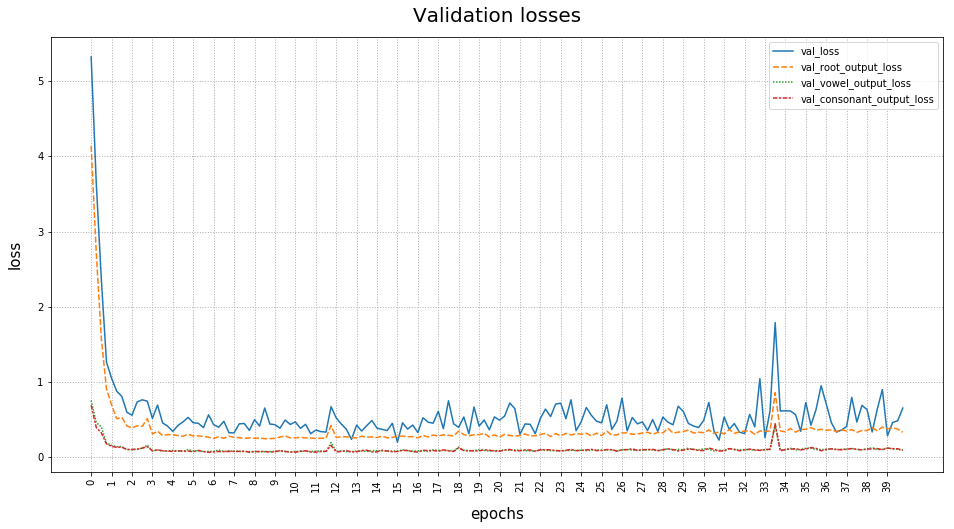

In [18]:
# displaying loss on validation set

fig, ax1 = plt.subplots(figsize=(16,8))
ax1 = sns.lineplot(data=results_df.loc[:,['val_loss', 'val_root_output_loss', 
                                          'val_vowel_output_loss',
                                          'val_consonant_output_loss']], linestyle=None)
ax1.set_xlabel('epochs', labelpad=15, fontsize=15)
ax1.set_ylabel('loss', labelpad=15, fontsize=15)
ax1.set_title('Validation losses', pad=15, fontsize=20)
plt.xticks(ticks=np.arange(0,results_df.shape[0],4), 
           labels=np.arange(0,int(results_df.shape[0]/4),1).tolist(), rotation=90)
ax1.grid(axis='both', linestyle=':', linewidth=1)

## Losses on training set

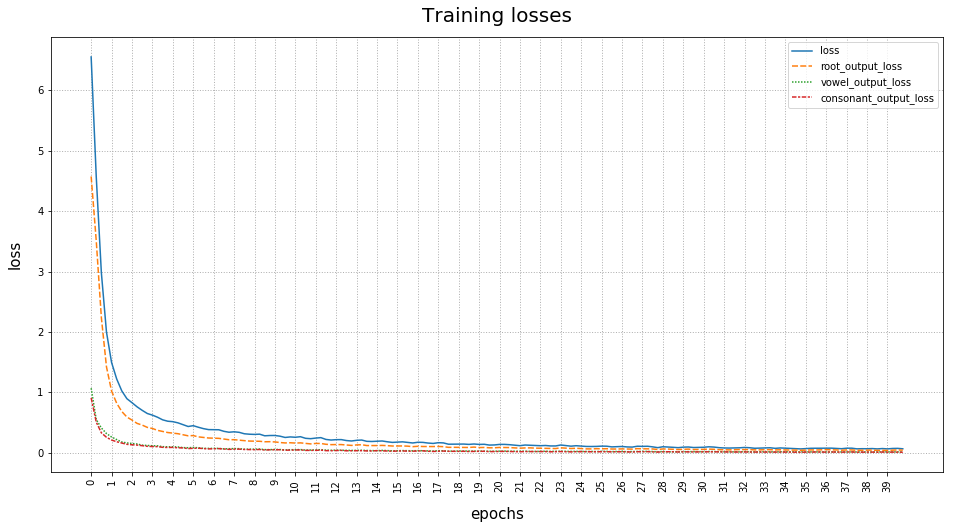

In [19]:
# displaying loss on train set

fig, ax2 = plt.subplots(figsize=(16,8))
ax2 = sns.lineplot(data=results_df.loc[:,['loss', 'root_output_loss',
                                          'vowel_output_loss', 
                                          'consonant_output_loss']], linestyle=None)
ax2.set_xlabel('epochs', labelpad=15, fontsize=15)
ax2.set_ylabel('loss', labelpad=15, fontsize=15)
ax2.set_title('Training losses', pad=15, fontsize=20)
plt.xticks(ticks=np.arange(0,results_df.shape[0],4), 
           labels=np.arange(0,int(results_df.shape[0]/4),1).tolist(), rotation=90)
ax2.grid(axis='both', linestyle=':', linewidth=1)

# Inference

In [20]:
submission_df = pd.DataFrame(columns=['row_id', 'target'])
for i in range(4): 
    
    # Loading test data and reshaping them as array
    test_df = pd.read_parquet(f'/kaggle/input/bengaliai-cv19/test_image_data_{i}.parquet')
    resized = test_df.iloc[:, 1:32333].values.reshape(-1, HEIGHT, WIDTH)
    
    # Resizing and cropping test data like it was done for training data
    cropped_df = crop_and_resize_images(test_df, resized, CROP_SIZE)
    test_index = cropped_df['image_id'].values.tolist()
    X_test = cropped_df.iloc[:,1:].values.reshape(-1, CROP_SIZE, CROP_SIZE, 1)/255
    
    del test_df
    del resized
    del cropped_df
    
    # make prediction on test images
    preds = model.predict(X_test)
    
    del X_test
    
    # Converting predictions to 3 lists (one for each target)
    root_preds = preds[0].argmax(axis=1).tolist()
    vowel_preds = preds[1].argmax(axis=1).tolist()
    consonant_preds = preds[2].argmax(axis=1).tolist()

    # Creating a 3 lines dataframe (root, vowel, consonant) for each row 
    # in predictions lists and appending them together
    for image_id, root, vowel, consonant in zip(test_index, root_preds, vowel_preds, 
                                                consonant_preds):
        
        root_row = {'row_id': image_id+'_grapheme_root', 'target':root}
        vowel_row = {'row_id': image_id+'_vowel_diacritic', 'target':vowel}
        consonant_row = {'row_id': image_id+'_vowel_diacritic', 'target':consonant}
        submission_df = submission_df.append(pd.DataFrame([root_row, vowel_row, 
                                                           consonant_row]), 
                                             ignore_index=True)
    
    del preds
    del root_preds
    del vowel_preds
    del consonant_preds
    gc.collect

# Save prediction as csv for submission
submission_df.to_csv('submission.csv',index=False)

100%|██████████| 3/3 [00:00<00:00, 298.58it/s]


In [21]:
display(submission_df)

,row_id,target
0,Test_0_grapheme_root,3
1,Test_0_vowel_diacritic,0
2,Test_0_vowel_diacritic,0
3,Test_1_grapheme_root,93
4,Test_1_vowel_diacritic,2
5,Test_1_vowel_diacritic,0
6,Test_2_grapheme_root,19
7,Test_2_vowel_diacritic,0
8,Test_2_vowel_diacritic,0
9,Test_3_grapheme_root,115
